<a href="https://colab.research.google.com/github/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/02_crispr_counts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing counts data from a CRISPR screen

In this exercise will we take a pregenerated set of CRISP screen data R!







## Setup

We'll start by loading a couple of R dependencies and then read the data in.

For those newer to R, this notebook loads the `tidyverse` meta package: a set of software tools which builds on base R to make data-wrangling and exploration more enjoyable. The code also makes use of the `|>` pipe functionality in R, which simplifies the passing the results of a function to another. Some of you might recognise its progenitor – `%>%` – which was prevalent in older versions of R.


## Setup our R session

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
# Load our dependencies
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Reading counts into R

Let's start by reading in the counts file we made in the last notebook.
Note: you may need to alter the path that you read the guides from if you re-configured the counting notebook in any way.


In [6]:

%%R
guide_counts <- read_tsv("reads_hap1.txt") |>
  pivot_longer(cols = contains("HAP1"), values_to = "counts", names_to = "sample")

Rows: 71090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): SEQUENCE, GENE
dbl (4): HAP1_T0, HAP1_T18A, HAP1_T18B, HAP1_T18C

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 × 4
  SEQUENCE             GENE  sample    counts
  <chr>                <chr> <chr>      <dbl>
1 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T0      239
2 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18A    245
3 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18B    230
4 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18C     62
5 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T0     1647
6 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T18A    415


We can glance at the first few lines
with:

In [8]:
%%R
head(guide_counts)

# A tibble: 6 × 4
  SEQUENCE             GENE  sample    counts
  <chr>                <chr> <chr>      <dbl>
1 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T0      239
2 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18A    245
3 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18B    230
4 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18C     62
5 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T0     1647
6 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T18A    415


When you have CRISPR counts data like this data frame, it is often helpful to visualise it so that you can better understand whether the sample meets you expectations

For a typical genome wide CRISPR screen, would hope that all of the guides seqeunces are observed in our sample (with counts >0) and that there is sufficient coverage for each guide in the library for us to perform statistical tests in downstream tools like MAGECK. Let's check this now:

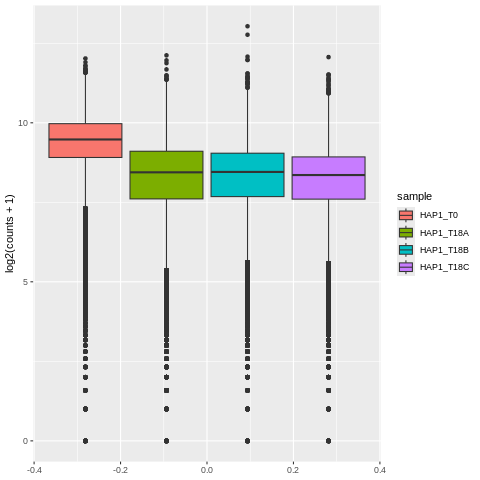

In [11]:
%%R
# You can represent in a more condensed way with a boxplot - highlighting the mean of the dataset,
# the range of guide counts in the dataset and any guides with extremely high or low counts.
ggplot(guide_counts, aes(y=log2(counts+1))) +
geom_boxplot(aes(fill = sample))

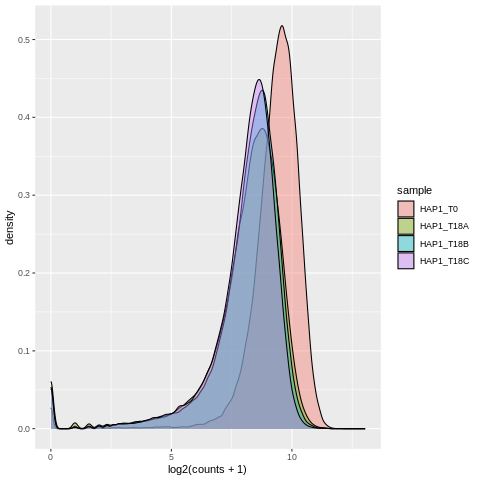

In [14]:
%%R
# Plot the distribution of counts across the different guides in the screen
ggplot(guide_counts, aes(x=log2(counts+1))) +
geom_density(aes(fill = sample), alpha = 0.4)

From eyeballing the graph what do you estimate is the mean number of counts per guide RNA in our sample? How many counts-per-guide do you think would be necessary for us to perform a CRISPR dropout screen?

In [15]:
!conda install bioconda::mageck

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bioconda::mageck


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-2.4.1            |     pyhd8ed1ab_0          28 KB  conda-forge
    decorator-5.1.1            |     pyhd8ed1ab_0          12 KB  conda-forge
    exceptiongroup-1.2.2       |     pyhd8ed1ab_0          20 KB  conda-forge
    executing-2.1.0            |     pyhd8ed1ab_0          28 KB  conda-forge
    ipython-8.27.0             |     pyh707e725_0         585 KB  conda-forge
    jedi-0.19.1                |     pyhd8ed1ab_0         

In [17]:
!mageck -h

usage: mageck [-h] [-v] {count,test,pathway,plot,mle} ...

mageck: performs sgRNA, gene and pathway analysis on CRISPR-Cas9 screening data.

positional arguments:
  {count,test,pathway,plot,mle}
                        commands to run mageck
    count               Collecting read counts from fastq files.
    test                Perform statistical test from a given count table (generated by count
                        command).
    pathway             Perform significant pathway analysis from gene rankings generated by the
                        test command.
    plot                Generating graphics for selected genes.
    mle                 Perform MLE estimation of gene essentiality.

options:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit


In [23]:
!mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file


INFO  @ Tue, 10 Sep 2024 09:59:31: Parameters: /usr/local/bin/mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file 
INFO  @ Tue, 10 Sep 2024 09:59:31: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Tue, 10 Sep 2024 09:59:31: Loading count table from reads_hap1.txt  
INFO  @ Tue, 10 Sep 2024 09:59:31: Processing 1 lines.. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loaded 71090 records. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading Rnw template file: /usr/local/lib/python3.10/site-packages/mageck/test_report.Rmd. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading R template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template.RTemplate. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading R template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template_indvgene.RTemplate. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Loading Rnw template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template.Rnw. 
INFO  @ Tue, 10 Sep 2024 09:59:32: Treatment samples:

In [31]:
  %%R
non_essential <- read_tsv("/content/NEGv1.txt") |>
select(GENE) |>
mutate(type = "non-essential")

essential <- read_tsv("/content/CEGv2.txt") |>
select(GENE) |>
mutate(type = "essential")


essentiality_class <- bind_rows(non_essential, essential)


Rows: 927 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 684 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Error in `group_by()`:
! Must group by variables found in `.data`.
✖ Column `type` is not found.
Run `rlang::last_trace()` to see where the error occurred.

Error in group_by(plot_data, type) : 
✖ Column `type` is not found.


## Validating the results of a screen

In order to have confidence that CRISPR-Cas9 is cutting and selecting against essential genes in your experiment many CRISPR libraries include a set of common essential genes (CEGs) and non-essential genes (NEG).

This positive and negative control set can be expected to deplete (CEGs) and remain constant (NEGs).

One effective way to check the success of a screen is to use a summary stastistic that descibed Null normalised mean difference (NNMD).

In [39]:
%%R
plot_data <- read_tsv("/content/sample1.HAP1_T18A_vs_HAP1_T0.gene_summary.txt")

annotated_data <- left_join(plot_data, essentiality_class, by = c("id" = "GENE"))

Rows: 18055 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id
dbl (13): num, neg|score, neg|p-value, neg|fdr, neg|rank, neg|goodsgrna, neg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [53]:
%%R
  # Calculate nnmd
  nnmd <- annotated_data |>
    dplyr::rename(LFC = `neg|lfc`) |>
    group_by(type) |>
    summarise(mean_lfc = mean(LFC), sd_lfc = sd(LFC)) |>
    pivot_wider(names_from = type,
                values_from = c(mean_lfc, sd_lfc)) |>
    mutate(nnmd = (`mean_lfc_essential` - `mean_lfc_non-essential`) /
                 `sd_lfc_non-essential`) |>
    mutate(nnmd_label = sprintf('NNMD = %.2f', nnmd))
  nnmd

# A tibble: 1 × 8
  mean_lfc_essential `mean_lfc_non-essential` mean_lfc_NA sd_lfc_essential
               <dbl>                    <dbl>       <dbl>            <dbl>
1              -3.01                    0.157      -0.112             1.65
# ℹ 4 more variables: `sd_lfc_non-essential` <dbl>, sd_lfc_NA <dbl>,
#   nnmd <dbl>, nnmd_label <chr>


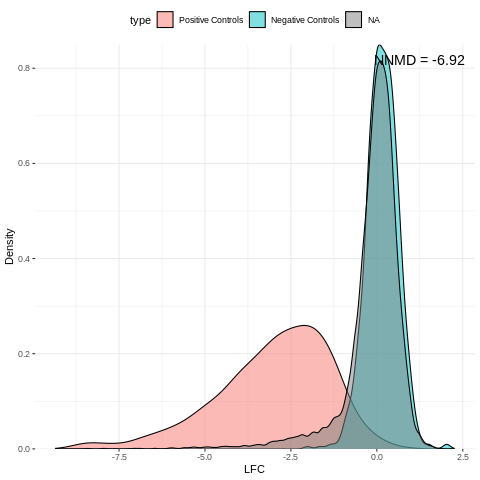

In [54]:

%%R
ggplot(annotated_data, aes(x = `neg|lfc`, fill = type)) +
          geom_density(alpha = 0.5) +
          labs(x = "LFC", y = "Density") +
          theme_bw() +
          theme(legend.position = "top", panel.border = element_blank()) +
          scale_fill_discrete(
            labels = c("Positive Controls", "Negative Controls")
          ) +
          scale_y_continuous(expand = c(0, 0)) +
          annotate(
            "text", x = Inf, y = Inf, label = nnmd[["nnmd_label"]],
            hjust = 1.1, vjust = 2, size = 5, colour = "black"
          )


## Post processing

[CRISPRcleanR](https://www.sanger.ac.uk/tool/crisprcleanr/) applies circular binary segmentation algorithm to identify genomic regions where sgRNA impact is correlated.

Unlikely that contigous genes will be equally essential - instead possible that difference is due to a copy number alteration

That's it for today! In many ways we've only just started, we might want to look at filtering guides out of our dataset, identifying problematic samples using tools like PCA and perfoming associations testing on our guides.

Stay tuned and see you next time!

## References
- [Integrated cross-study datasets of genetic dependencies in cancer](https://www.nature.com/articles/s41467-021-21898-7)

- [Extracting Biological Insights from the Project Achilles Genome-Scale CRISPR Screens in Cancer Cell Lines](https://www.biorxiv.org/content/10.1101/720243v1)
